In [26]:
!pip install -q keras-tuner

In [27]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import drive
from tqdm.notebook import tqdm
import keras_tuner as kt
import matplotlib.pyplot as plt


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
df = pd.read_pickle("/content/drive/MyDrive/Deep Dive 12/ppd/final_dataset.pkl")

In [30]:
df.head()

,unique_id,price_paid,date,postcode,property_type,new_build,tenure,saon,paon,street,locality,town,district,county,transaction_category,linked_data_uri,year,month,month_sin,month_cos,postcode_outward,postcode_sector,join_key,avg_area,avg_rooms,Year,district_key,area_key,Population,Live_Births,Median_Annual_Earnings,Inactivity_Rate_Percent,HP_Residence_Ratio,HP_Workplace_Ratio
0,25EA59F9-A161-4D50-E050-A8C0630562D0,455000,2015-10-23,E1 0AE,F,N,L,<NA>,338,CABLE STREET,NaN,LONDON,TOWER HAMLETS,GREATER LONDON,A,http://landregistry.data.gov.uk/data/ppi/trans...,2015,10,-8.660254e-01,0.5,E1,E1,E10AE,70.263529,3.039216,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78
1,BA8840F9-5801-45B5-B164-963078664015,378000,2015-08-25,E1 0AE,F,N,L,<NA>,362,CABLE STREET,NaN,LONDON,TOWER HAMLETS,GREATER LONDON,A,http://landregistry.data.gov.uk/data/ppi/trans...,2015,8,-8.660254e-01,-0.5,E1,E1,E10AE,70.263529,3.039216,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78
2,23B6165D-D01F-FCF4-E050-A8C0620577FA,450000,2015-06-18,E1 0AH,F,N,L,LOWER GROUND AND GROUND FLOOR FLAT,387,CABLE STREET,NaN,LONDON,TOWER HAMLETS,GREATER LONDON,A,http://landregistry.data.gov.uk/data/ppi/trans...,2015,6,1.224647e-16,-1.0,E1,E1,E10AH,66.500000,3.000000,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78
3,25EA59F9-A320-4D50-E050-A8C0630562D0,225000,2015-10-02,E1 0AN,F,N,L,FLAT 10,KNOWLDEN HOUSE,CABLE STREET,NaN,LONDON,TOWER HAMLETS,GREATER LONDON,A,http://landregistry.data.gov.uk/data/ppi/trans...,2015,10,-8.660254e-01,0.5,E1,E1,E10AN,42.964667,1.800000,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78
4,288DCE29-01AE-E510-E050-A8C06205480E,340000,2015-10-30,E1 0AP,F,N,L,FLAT 25,THORNEWILL HOUSE,CABLE STREET,NaN,LONDON,TOWER HAMLETS,GREATER LONDON,A,http://landregistry.data.gov.uk/data/ppi/trans...,2015,10,-8.660254e-01,0.5,E1,E1,E10AP,48.392424,2.000000,2015,TOWER HAMLETS,TOWER HAMLETS,282674.0,1157.7775,46681.0,22.6,11.89,8.78


In [31]:
df.describe()

,price_paid,date,year,month,month_sin,month_cos,avg_area,avg_rooms,Year,Population,Live_Births,Median_Annual_Earnings,Inactivity_Rate_Percent,HP_Residence_Ratio,HP_Workplace_Ratio
count,6.930550e+05,693055,693055.000000,693055.000000,6.930550e+05,6.930550e+05,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000,693055.000000
mean,9.634250e+05,2019-11-16 13:25:26.803500544,2019.365097,6.613791,-2.372781e-02,-1.721330e-02,81.322288,3.650129,2019.365097,288945.212315,979.710263,37096.571087,21.192349,14.806939,15.734238
min,1.000000e+02,2015-01-01 00:00:00,2015.000000,1.000000,-1.000000e+00,-1.000000e+00,0.000000,1.000000,2015.000000,7668.000000,14.405000,26230.000000,8.800000,8.240000,7.120000
25%,3.750000e+05,2017-05-02 00:00:00,2017.000000,4.000000,-8.660254e-01,-8.660254e-01,63.830882,3.000000,2017.000000,261814.000000,826.112500,32404.000000,17.800000,12.660000,12.870000
50%,5.287500e+05,2019-11-22 00:00:00,2019.000000,7.000000,-2.449294e-16,-1.836970e-16,75.456190,3.650134,2019.000000,300924.000000,1045.452500,35575.000000,21.200000,13.800000,14.660000
75%,8.100000e+05,2022-04-26 00:00:00,2022.000000,10.000000,5.000000e-01,5.000000e-01,88.064704,4.068182,2022.000000,330447.000000,1171.270000,40000.000000,24.500000,15.350000,17.210000
max,5.943000e+08,2024-12-31 00:00:00,2024.000000,12.000000,1.000000e+00,1.000000e+00,2232.000000,37.000000,2024.000000,409342.000000,1580.092500,64995.000000,35.700000,34.770000,43.970000
std,4.406309e+06,NaN,2.863565,3.395191,7.102599e-01,7.033300e-01,34.496406,1.057592,2.863565,63072.429083,275.604782,6424.643283,4.813257,3.799742,5.188515


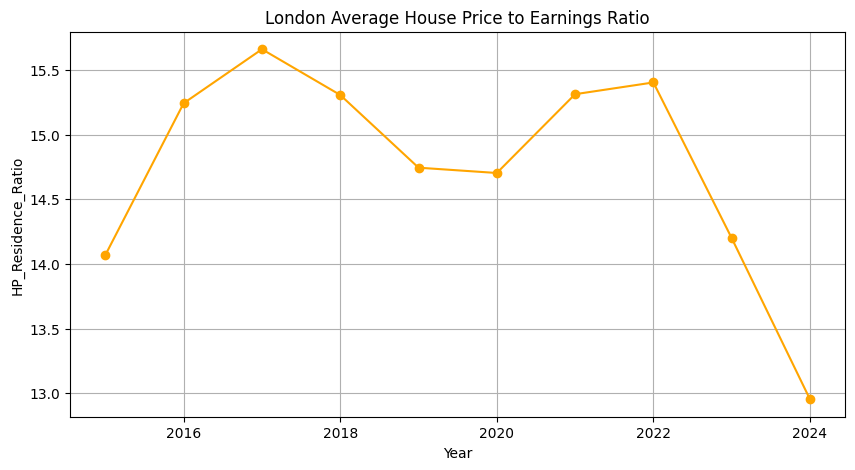

In [32]:
df_mean = df.groupby("Year")["HP_Residence_Ratio"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(df_mean["Year"], df_mean["HP_Residence_Ratio"], marker="o", color="orange")
plt.title("London Average House Price to Earnings Ratio")
plt.xlabel("Year")
plt.ylabel("HP_Residence_Ratio")
plt.grid(True)
plt.show()


In [33]:
df.columns

Index(['unique_id', 'price_paid', 'date', 'postcode', 'property_type', 'new_build', 'tenure', 'saon', 'paon', 'street', 'locality', 'town', 'district', 'county', 'transaction_category', 'linked_data_uri', 'year', 'month', 'month_sin', 'month_cos', 'postcode_outward', 'postcode_sector', 'join_key', 'avg_area', 'avg_rooms', 'Year', 'district_key', 'area_key', 'Population', 'Live_Births', 'Median_Annual_Earnings', 'Inactivity_Rate_Percent', 'HP_Residence_Ratio', 'HP_Workplace_Ratio'], dtype='object')

In [34]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

df['log_price'] = np.log1p(df['price_paid'])
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

cat_cols = ['property_type', 'new_build', 'tenure', 'transaction_category']

df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, dtype=float)

encoded_cols = [c for c in df.columns if any(c.startswith(cat + '_') for cat in cat_cols)]

len(encoded_cols)



11

In [35]:
macro_cols = [
    'Population',
    'Live_Births',
    'Median_Annual_Earnings',
    'Inactivity_Rate_Percent',
    'HP_Residence_Ratio',
    'HP_Workplace_Ratio'
]
df = df.dropna(subset=macro_cols)
df['month_date'] = df['date'] + pd.offsets.MonthBegin(-1)
agg_dict = {
    'log_price': 'median',
    'price_paid': ['median', 'count'],
    'month_sin': 'first',
    'month_cos': 'first',
    'avg_area': 'mean',
    'avg_rooms': 'mean'
}

for col in encoded_cols:
    agg_dict[col] = 'mean'

for col in macro_cols:
    agg_dict[col] = 'mean'

mo = (
    df.groupby(['postcode_outward', 'month_date'], observed=True)
      .agg(agg_dict)
      .reset_index()
      .sort_values(['postcode_outward', 'month_date'])
)


mo.columns = ['_'.join(col).strip() if col[1] else col[0] for col in mo.columns.values]
mo = mo.rename(columns={'price_paid_count': 'txn_count', 'price_paid_median': 'price_paid'})

mo.columns = [
    c.replace('_mean', '').replace('_first', '').replace('_median', '').replace('log_price_median', 'log_price')
    if c not in ['txn_count', 'price_paid', 'log_price'] else c
    for c in mo.columns
]

print("mo shape：", mo.shape)
print(mo.head())


mo shape： (18779, 26)
  postcode_outward month_date  log_price  price_paid  txn_count  month_sin     month_cos   avg_area  avg_rooms  property_type_D  property_type_F  property_type_O  property_type_S  property_type_T  new_build_N  new_build_Y  tenure_F  tenure_L  transaction_category_A  transaction_category_B     Population  Live_Births  Median_Annual_Earnings  Inactivity_Rate_Percent  HP_Residence_Ratio  HP_Workplace_Ratio
0             DA15 2023-07-01  13.384729    650000.0          1  -0.866025 -5.000000e-01  88.391200   4.681818              0.0         0.000000         0.000000         1.000000         0.000000     1.000000     0.000000  1.000000  0.000000                1.000000                0.000000  296420.000000   913.512500            37420.000000                13.900000           11.670000           12.560000
1             DA15 2024-02-01  13.091906    485000.0          1   0.866025  5.000000e-01  88.391200   4.681818              0.0         0.000000         0.000000   

In [36]:
mo['area_log_price_3m'] = mo.groupby('postcode_outward')['log_price'] \
                              .transform(lambda x: x.rolling(3, min_periods=1).mean())

mo['area_log_price_6m'] = mo.groupby('postcode_outward')['log_price'] \
                              .transform(lambda x: x.rolling(6, min_periods=1).mean())



In [37]:
for k in [1, 2, 3]:
    mo[f'lag{k}'] = mo.groupby('postcode_outward')['log_price'].shift(k)

for col_name in ['lag1', 'lag2', 'lag3']:
    mo[col_name] = mo.groupby('postcode_outward')[col_name].transform(lambda x: x.ffill().bfill())

In [38]:
mo_clean = mo[(mo['txn_count'] > 5) & (mo['log_price'] > 10) & (mo['log_price'] < 16)].copy()

exclude_cols = [
    'postcode_outward',
    'month_date',
    'price_paid',
    'log_price',
]

feature_cols = [c for c in mo_clean.columns if c not in exclude_cols]

print("Data Prepared.")
print("Samples:", len(mo_clean))
print("Feature count:", len(feature_cols))
print("Example features:", feature_cols[:15])



Data Prepared.
Samples: 15155
Feature count: 27
Example features: ['txn_count', 'month_sin', 'month_cos', 'avg_area', 'avg_rooms', 'property_type_D', 'property_type_F', 'property_type_O', 'property_type_S', 'property_type_T', 'new_build_N', 'new_build_Y', 'tenure_F', 'tenure_L', 'transaction_category_A']


In [39]:
mo_clean.columns

Index(['postcode_outward', 'month_date', 'log_price', 'price_paid', 'txn_count', 'month_sin', 'month_cos', 'avg_area', 'avg_rooms', 'property_type_D', 'property_type_F', 'property_type_O', 'property_type_S', 'property_type_T', 'new_build_N', 'new_build_Y', 'tenure_F', 'tenure_L', 'transaction_category_A', 'transaction_category_B', 'Population', 'Live_Births', 'Median_Annual_Earnings', 'Inactivity_Rate_Percent', 'HP_Residence_Ratio', 'HP_Workplace_Ratio', 'area_log_price_3m', 'area_log_price_6m', 'lag1', 'lag2', 'lag3'], dtype='object')

In [40]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(mo_clean.head(2))


  postcode_outward month_date  log_price  price_paid  txn_count  month_sin  month_cos   avg_area  avg_rooms  property_type_D  property_type_F  property_type_O  property_type_S  property_type_T  new_build_N  new_build_Y  tenure_F  tenure_L  transaction_category_A  transaction_category_B     Population  Live_Births  Median_Annual_Earnings  Inactivity_Rate_Percent  HP_Residence_Ratio  HP_Workplace_Ratio  area_log_price_3m  area_log_price_6m       lag1       lag2       lag3
2               E1 2015-01-01  12.861001    385000.0         41   0.500000   0.866025  63.301870   2.910831              0.0         0.902439         0.024390              0.0         0.073171      0.97561      0.02439  0.097561  0.902439                0.853659                0.146341  275966.536585  1130.267073            46860.341463                22.917073           11.961707            8.937805          12.861001          12.861001  12.861001  12.861001  12.861001
3               E1 2015-02-01  12.987691    437000

In [41]:

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_vals = scaler_X.fit_transform(mo_clean[feature_cols])
y_vals = scaler_y.fit_transform(mo_clean[['log_price']])

df_scaled = pd.DataFrame(X_vals, columns=feature_cols, index=mo_clean.index)
df_scaled['postcode'] = mo_clean['postcode_outward']
df_scaled['time'] = mo_clean['month_date']
df_scaled['target'] = y_vals

TIME_STEPS = 12

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for code, group in tqdm(df_scaled.groupby('postcode'), desc="Grouping Sequences"):
    group = group.sort_values('time')

    if len(group) <= TIME_STEPS:
        continue

    g_X = group[feature_cols].values
    g_y = group['target'].values

    local_X, local_y = [], []
    for i in range(len(group) - TIME_STEPS):
        local_X.append(g_X[i:(i + TIME_STEPS)])
        local_y.append(g_y[i + TIME_STEPS])

    local_X = np.array(local_X)
    local_y = np.array(local_y).reshape(-1, 1)

    split_idx = int(len(local_X) * 0.8)
    if split_idx == 0:
        continue

    X_train_list.append(local_X[:split_idx])
    y_train_list.append(local_y[:split_idx])
    X_test_list.append(local_X[split_idx:])
    y_test_list.append(local_y[split_idx:])

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test  = np.concatenate(X_test_list, axis=0)
y_test  = np.concatenate(y_test_list, axis=0)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)



Grouping Sequences:   0%|          | 0/159 [00:00<?, ?it/s]

Training Set Shape: (10637, 12, 27)
Test Set Shape: (2729, 12, 27)


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

tf.random.set_seed(42)

n_features = X_train.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 64)         │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,513 (142.63 KB)

 Trainable params: 36,513 (142.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.2541 - mae: 0.3762 - val_loss: 0.5779 - val_mae: 0.5146
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1504 - mae: 0.2784 - val_loss: 0.5755 - val_mae: 0.5105
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1345 - mae: 0.2615 - val_loss: 0.6204 - val_mae: 0.5349
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1356 - mae: 0.2651 - val_loss: 0.6200 - val_mae: 0.5285
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1307 - mae: 0.2563 - val_loss: 0.6156 - val_mae: 0.5237
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1292 - mae: 0.2553 - val_loss: 0.5978 - val_mae: 0.5231
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1357 - mae: 0.2659 - val_loss: 0.5910 - val_mae: 0.5217
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1244 - mae: 0.2521 - val_loss: 0.5979 - val_mae: 0.5206
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/

In [43]:
from sklearn.metrics import mean_absolute_error

y_test_pred_scaled = model.predict(X_test)
y_test_log = scaler_y.inverse_transform(y_test)
y_pred_log = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_price = np.expm1(y_test_log)
y_pred_price = np.expm1(y_pred_log)

mae_log = mean_absolute_error(y_test_log, y_pred_log)
mae_price = mean_absolute_error(y_test_price, y_pred_price)

print(f"MAE_log: {mae_log:.4f}")
print(f"MAE: {mae_price:,.2f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MAE_log: 0.1395
MAE: 126,257.91


In [44]:
def calculate_mae(y_true, y_pred):
    """MAE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

try:
    y_test_price, y_pred_price
except NameError:
    y_test_price = np.random.uniform(300000, 600000, 200)
    y_pred_price = y_test_price * (1 + np.random.normal(0, 0.1, 200))

mae_result = calculate_mae(y_test_price, y_pred_price)

mae_result

np.float64(126257.91436302378)

In [45]:
from sklearn.metrics import median_absolute_error, mean_squared_error
medae_result = median_absolute_error(y_test_price, y_pred_price)

y_test_log = np.log(y_test_price)
y_pred_log = np.log(y_pred_price)

rmse_log_result = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

print(f"MedAE: £{medae_result:,.0f}")
print(f"RMSE_log: {rmse_log_result:.4f}")

MedAE: £55,576
RMSE_log: 0.2200


In [46]:

epsilon = 1e-8

mape = np.mean(np.abs((y_test_price - y_pred_price) / (y_test_price + epsilon))) * 100

mape #Percentage


np.float64(17.00219857391049)

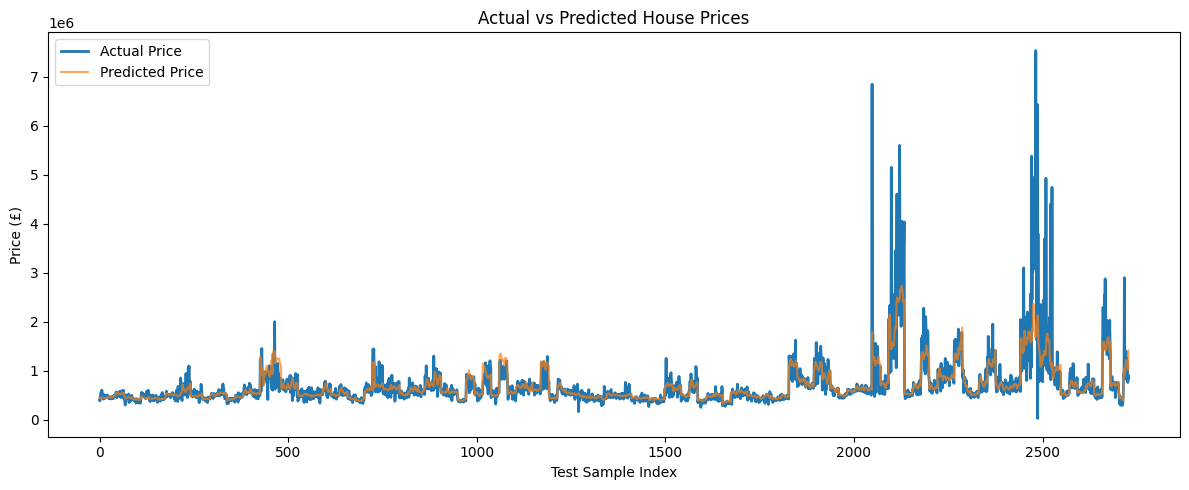

In [47]:
try:
    y_test_price, y_pred_price
except NameError:
    y_test_price = np.random.uniform(300000,600000,200)
    y_pred_price = y_test_price * (1 + np.random.normal(0,0.1,200))

plt.figure(figsize=(12,5))
plt.plot(y_test_price, label="Actual Price", linewidth=2)
plt.plot(y_pred_price, label="Predicted Price", alpha=0.7)
plt.title("Actual vs Predicted House Prices")
plt.xlabel("Test Sample Index")
plt.ylabel("Price (£)")
plt.legend()
plt.tight_layout()
plt.show()


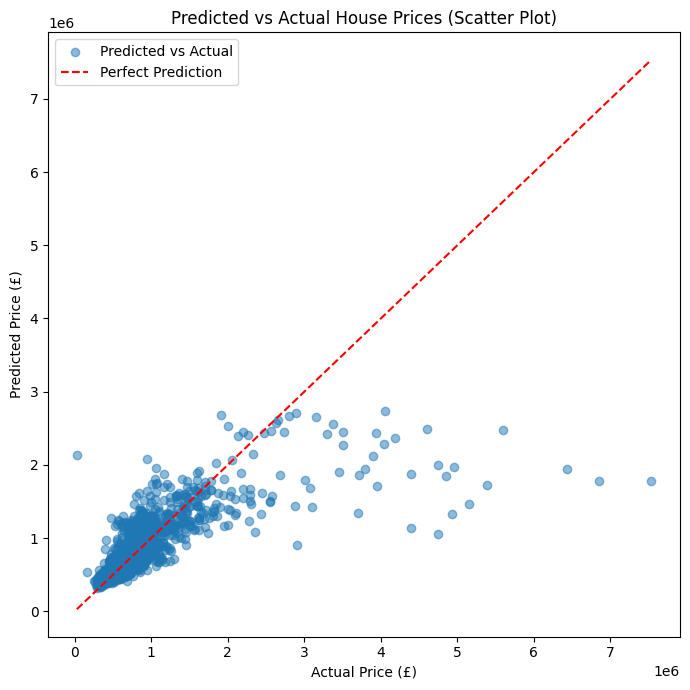

In [48]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test_price, y_pred_price, alpha=0.5, label="Predicted vs Actual")

min_val = min(y_test_price.min(), y_pred_price.min())
max_val = max(y_test_price.max(), y_pred_price.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")

plt.title("Predicted vs Actual House Prices (Scatter Plot)")
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.legend()
plt.tight_layout()
plt.savefig('predicted_vs_actual_scatter_plot.png')

In [49]:

y_test_pred_scaled = model.predict(X_test)
y_pred_log = scaler_y.inverse_transform(y_test_pred_scaled)
y_true_log = scaler_y.inverse_transform(y_test)

baseline_mae = mean_absolute_error(y_true_log, y_pred_log)
print("Baseline MAE (log_price):", baseline_mae)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Baseline MAE (log_price): 0.13947736082814818


In [50]:
from sklearn.metrics import mean_absolute_error
import copy

def permutation_importance_lstm(model, X_test, y_test, feature_cols, scaler_y):
    """
    X_test: shape = (samples, time_steps, features)
    """
    results = {}

    # baseline MAE
    baseline_pred = model.predict(X_test)
    baseline_pred_log = scaler_y.inverse_transform(baseline_pred)
    y_true_log = scaler_y.inverse_transform(y_test)
    baseline_mae = mean_absolute_error(y_true_log, baseline_pred_log)

    print(f"Baseline MAE: {baseline_mae:.4f}")

    for fi, feat_name in enumerate(feature_cols):
        print(f"Testing feature: {feat_name}")

        X_test_shuffled = np.copy(X_test)
        for t in range(X_test.shape[1]):
            np.random.shuffle(X_test_shuffled[:, t, fi])
        y_pred_perm = model.predict(X_test_shuffled)
        y_pred_perm_log = scaler_y.inverse_transform(y_pred_perm)

        perm_mae = mean_absolute_error(y_true_log, y_pred_perm_log)

        results[feat_name] = perm_mae - baseline_mae

    return results

importance_scores = permutation_importance_lstm(
    model, X_test, y_test, feature_cols, scaler_y
)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Baseline MAE: 0.1395
Testing feature: txn_count
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Testing feature: month_sin
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing feature: month_cos
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing feature: avg_area
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing feature: avg_rooms
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Testing feature: property_type_D
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing feature: property_type_F
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing feature: property_type_O
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing feature: property_type_S
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing feature: property_type_T
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Testing feature: new_build_N
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing feature: new_build_Y
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Testing feature: tenure_F
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing feature: tenure_L
86/86 ━━━━━━━━━━━━━━━━━━

In [53]:
sorted_importance = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Feature importance ranking
for feat, score in sorted_importance:
    print(f"{feat:35s}  importance = {score:.5f}")


area_log_price_6m                    importance = 0.01314
area_log_price_3m                    importance = 0.00941
avg_area                             importance = 0.00687
lag1                                 importance = 0.00588
HP_Residence_Ratio                   importance = 0.00469
lag2                                 importance = 0.00460
lag3                                 importance = 0.00405
month_sin                            importance = 0.00312
month_cos                            importance = 0.00242
Live_Births                          importance = 0.00241
HP_Workplace_Ratio                   importance = 0.00229
property_type_S                      importance = 0.00189
new_build_Y                          importance = 0.00183
property_type_D                      importance = 0.00120
txn_count                            importance = 0.00114
transaction_category_A               importance = 0.00110
transaction_category_B               importance = 0.00108
tenure_F      

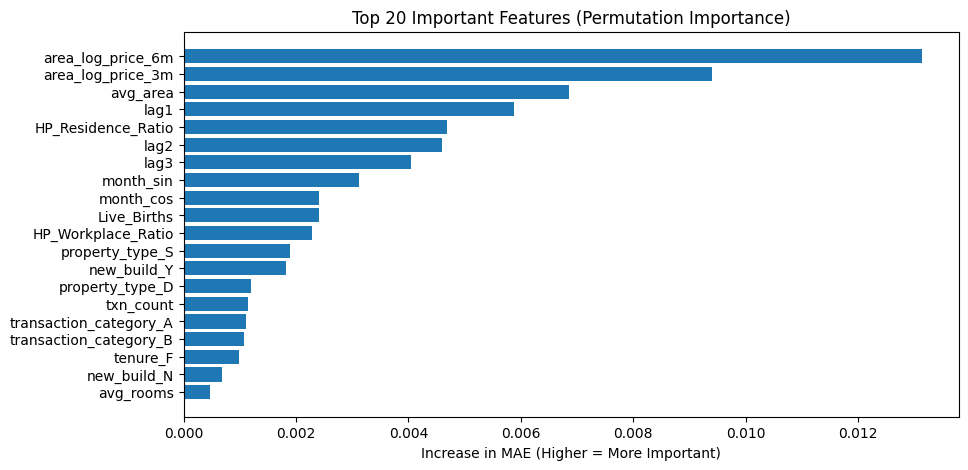

In [52]:
feat_names = [x[0] for x in sorted_importance[:20]]
feat_values = [x[1] for x in sorted_importance[:20]]

plt.figure(figsize=(10,5))
plt.barh(feat_names, feat_values)
plt.title("Top 20 Important Features (Permutation Importance)")
plt.xlabel("Increase in MAE (Higher = More Important)")
plt.gca().invert_yaxis()
plt.show()
